In [1]:
from google.colab import files
uploaded= files.upload()

Saving test.xlsx to test.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Project : Employee Sentiment Analysis**



**Project Description:**


This project involves analyzing an unlabeled dataset of employee messages to assess sentiment and engagement

Importing libraries

In [2]:
import pandas as pd
from textblob import TextBlob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

**2. Project Objective**

The main goal is to evaluate employee sentiment and engagement by performing the following:

· **Sentiment Labeling** :Automatically label each message as Positive, Negative, or Neutral.

·**Exploratory Data Analysis (EDA):**Analyze and visualize the data to understand its structure and underlying trends.

· **Employee Score Calculation:**Compute a monthly sentiment score for each employee based on their messages.

· **Employee Ranking**: Identify and rank employees by their sentiment scores.

·**Flight Risk Identification:** A Flight risk is any employee who has sent 4 or more negative mails in a given month.

· **Predictive Modeling:** Develop a linear regression model to further analyze sentiment trends.

In [3]:
#Load the dataset
df = pd.read_excel("test.xlsx")

# Rename columns for clarity
df = df.rename(columns={"from": "employee_id", "body": "message"})

# Drop rows with missing messages
df = df.dropna(subset=["message"])

# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")


Task 1: Sentiment Labeling


Labeling each employee message with one of three sentiment categories: Positive, Negative, or Neutral.

In [4]:

# STEP 2: SENTIMENT LABELING

def get_sentiment(text):
    try:
        polarity = TextBlob(str(text)).sentiment.polarity
        if polarity > 0.1:
            return "Positive"
        elif polarity < -0.1:
            return "Negative"
        else:
            return "Neutral"
    except:
        return "Neutral"


In [5]:
# Apply sentiment analysis
df["sentiment"] = df["message"].apply(get_sentiment)

Task 2 : Exploratory Data Analysis(EDA)

Understand the structure, distribution, and trends in the dataset through thorough exploration.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Subject         2191 non-null   object        
 1   message         2191 non-null   object        
 2   date            2191 non-null   datetime64[ns]
 3   employee_id     2191 non-null   object        
 4   sentiment       2191 non-null   object        
 5   message_length  2191 non-null   int64         
 6   month           2191 non-null   period[M]     
 7   score           2191 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(4), period[M](1)
memory usage: 137.1+ KB


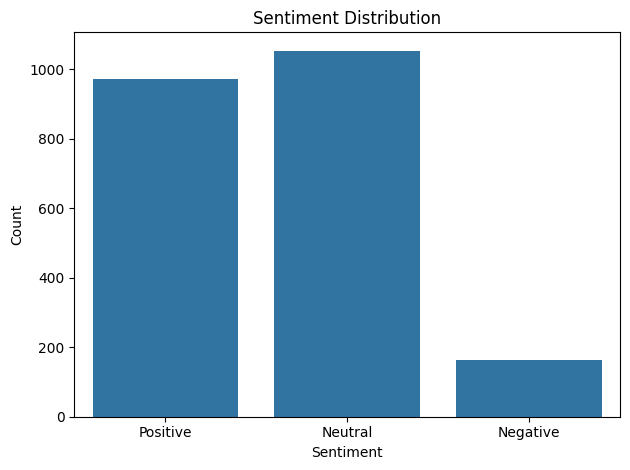

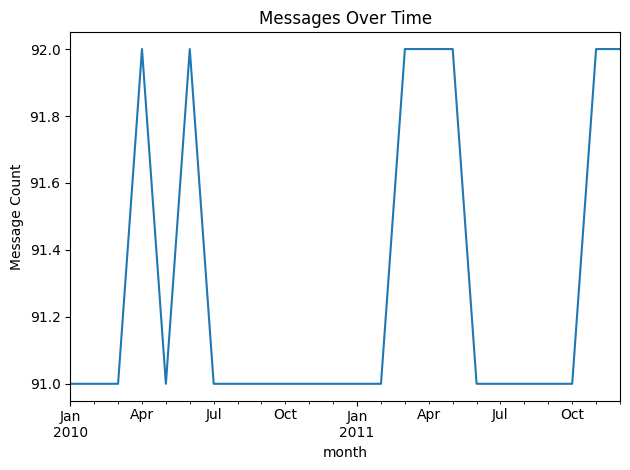

In [14]:
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
df['message_length'] = df['message'].apply(lambda x: len(str(x)))

# Plot sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visualization_sentiment_distribution.png")
plt.show()

# Plot messages over time
df['month'] = df['date'].dt.to_period('M')
df.groupby('month').size().plot(kind='line', title='Messages Over Time')
plt.ylabel('Message Count')
plt.tight_layout()
plt.savefig("visualization_messages_over_time.png")
plt.show()


Task 3 : Employee Score Calculation

Compute a monthly sentiment score for each employee based on their messages.

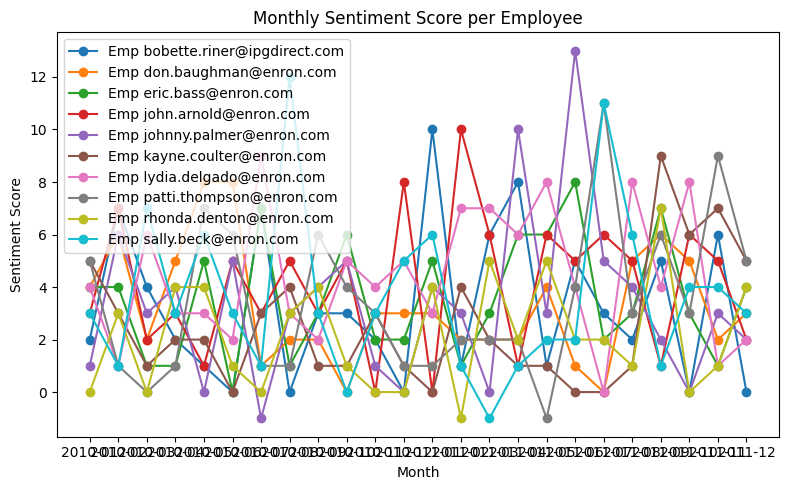

In [15]:
# STEP 4: EMPLOYEE SCORE CALCULATION
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['score'] = df['sentiment'].map(sentiment_map)
monthly_scores = df.groupby(['employee_id', 'month'])['score'].sum().reset_index()

# Plot employee sentiment scores
plt.figure(figsize=(8, 5))
for emp in monthly_scores['employee_id'].unique():
    subset = monthly_scores[monthly_scores['employee_id'] == emp]
    plt.plot(subset['month'].astype(str), subset['score'], marker='o', label=f'Emp {emp}')
plt.title("Monthly Sentiment Score per Employee")
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.legend()
plt.tight_layout()
plt.savefig("visualization_employee_scores.png")
plt.show()


Task 4: Employee Ranking

Generate ranked lists of employees based on their monthly sentiment scores.

<ipython-input-16-34b5e97889bd>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pos = df.groupby('month', group_keys=False).apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)
<ipython-input-16-34b5e97889bd>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_neg = df.groupby('month', group_keys=False).apply(lambda x: x.nsmallest(3, 'score')).reset_index(drop=True)


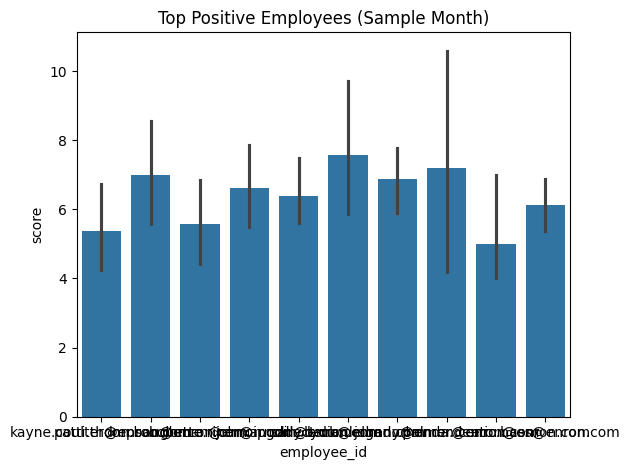

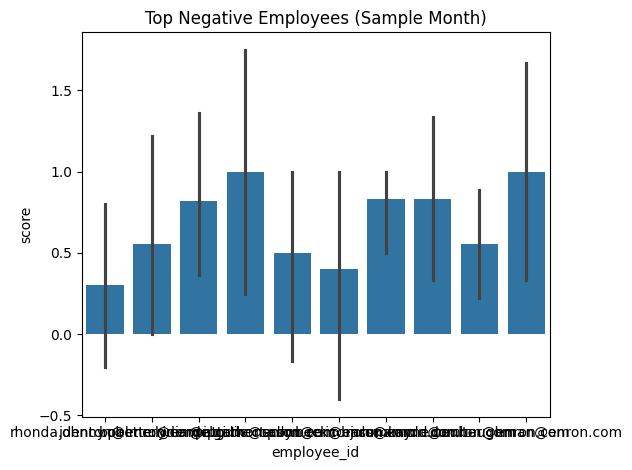

In [16]:
# STEP 5: EMPLOYEE RANKING
def rank_employees(df):
    top_pos = df.groupby('month', group_keys=False).apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)
    top_neg = df.groupby('month', group_keys=False).apply(lambda x: x.nsmallest(3, 'score')).reset_index(drop=True)
    return top_pos, top_neg

top_positive, top_negative = rank_employees(monthly_scores)

# Visualize top/bottom rankings
sns.barplot(x='employee_id', y='score', data=top_positive)
plt.title("Top Positive Employees (Sample Month)")
plt.tight_layout()
plt.savefig("visualization_top_positive.png")
plt.show()

sns.barplot(x='employee_id', y='score', data=top_negative)
plt.title("Top Negative Employees (Sample Month)")
plt.tight_layout()
plt.savefig("visualization_top_negative.png")
plt.show()

Task 5: Flight Risk Identification

Identify employees who are at risk of leaving based on their monthly sentiment scores.

In [9]:
# STEP 6: FLIGHT RISK IDENTIFICATION
flight_risk = []
for emp_id, group in df[df['sentiment'] == 'Negative'].groupby('employee_id'):
    dates = group['date'].sort_values().tolist()
    for i in range(len(dates)):
        count = 1
        for j in range(i+1, len(dates)):
            if (dates[j] - dates[i]).days <= 30:
                count += 1
            else:
                break
        if count >= 4:
            flight_risk.append(emp_id)
            break
flight_risk = list(set(flight_risk))

Task 7: Predictive Modeling

Develop a linear regression model to analyze sentiment trends and predict sentiment scores using a variety of independent variables that may influence sentiment scores.

Mean Squared Error: 3.93
R^2 Score: 0.43


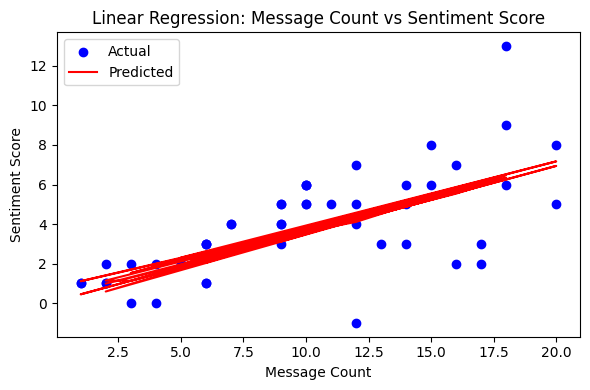

In [17]:
# STEP 7: PREDICTIVE MODELING
agg_df = df.groupby(['employee_id', 'month']).agg({
    'message_length': 'mean',
    'message': 'count',
    'score': 'sum'
}).rename(columns={'message': 'message_count'}).reset_index()

X = agg_df[['message_length', 'message_count']]
y = agg_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Linear regression visualization
plt.figure(figsize=(6, 4))
plt.scatter(X_test['message_count'], y_test, color='blue', label='Actual')
plt.plot(X_test['message_count'], model.predict(X_test), color='red', label='Predicted')
plt.xlabel("Message Count")
plt.ylabel("Sentiment Score")
plt.title("Linear Regression: Message Count vs Sentiment Score")
plt.legend()
plt.tight_layout()
plt.savefig("visualization_linear_regression.png")
plt.show()

In [11]:
# Final Outputs
df.to_csv("labeled_sentiment.csv", index=False)
monthly_scores.to_csv("employee_monthly_scores.csv", index=False)
top_positive.to_csv("top_positive_employees.csv", index=False)
top_negative.to_csv("top_negative_employees.csv", index=False)
pd.DataFrame(flight_risk, columns=['employee_id']).to_csv("flight_risk_employees.csv", index=False)
